# Lab: Nonlinear Least Squares for Modeling Materials¶

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Text(0.5, 1.0, 'y vs x')

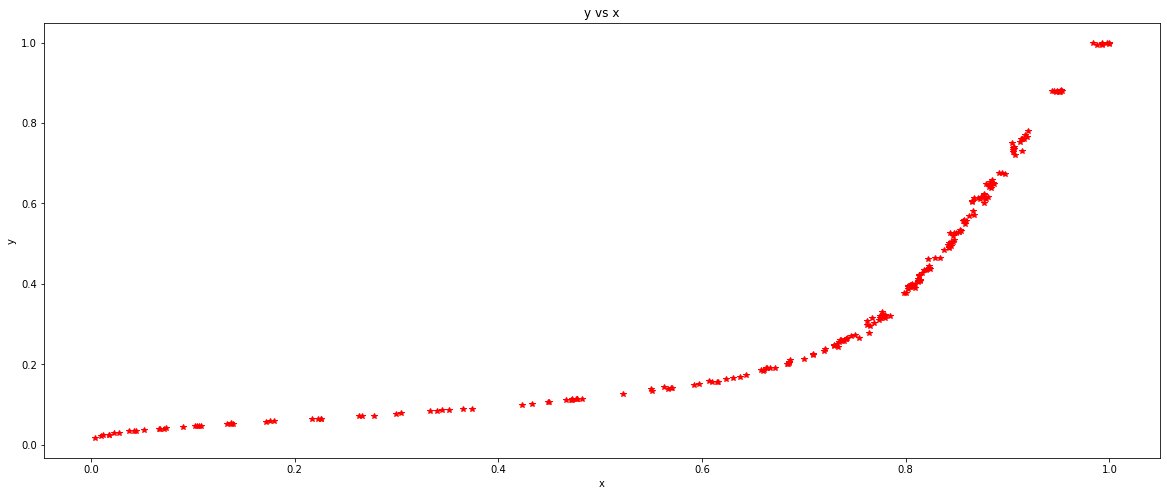

In [3]:
x0 = df['x0']
y0 = df['y0']
x = x0/np.max(x0)
y = y0/np.max(y0)
args = np.argsort(x)
x = x[args]
y = y[args]
x = np.asarray(x)
y = np.asarray(y)
plt.figure(figsize=(20,8))
plt.plot(x,y,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('y vs x')

Text(0, 0.5, 'yn')

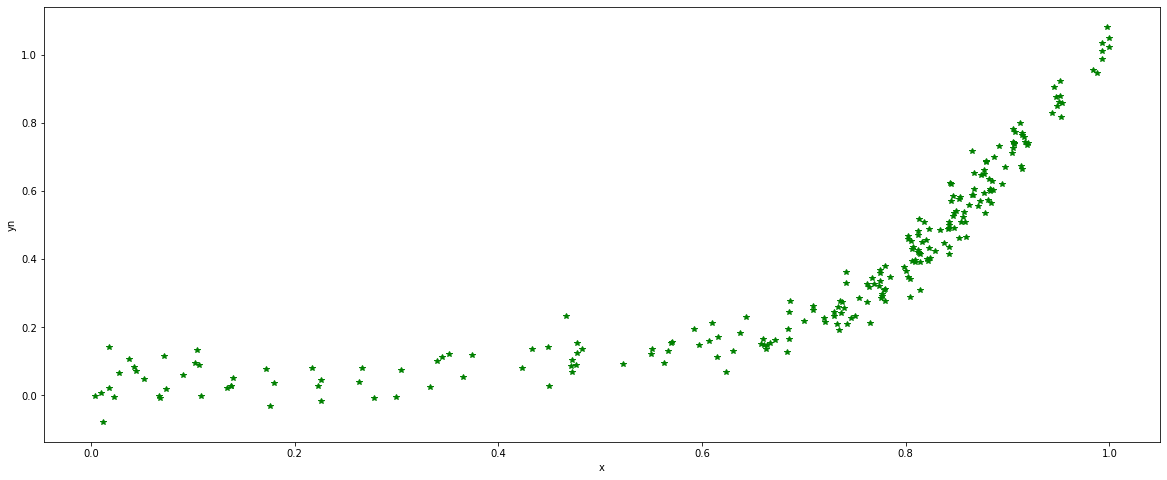

In [4]:
mu = 0
sigma = 0.05
yn = y + np.random.normal(mu,sigma,size=y.shape)
plt.figure(figsize=(20,8))
plt.plot(x,yn,'*g')
plt.xlabel('x')
plt.ylabel('yn')

In [5]:
from sklearn.model_selection import train_test_split
xtr, xts, ytr, yts = train_test_split(x, yn,test_size= 0.33,shuffle= True)
print(xtr.shape)

(158,)


# Initial Fit for a Rational Model

In [6]:
def predict(w,x):
    d = (len(w)-1)//2
    a = w[0: d+1]
    b = w[d+1:]
    a=np.flip(a)
    b = np.concatenate(([1],b))
    b=np.flip(b)
    yhat_a = np.polyval(a,x)
    yhat_b= np.polyval(b,x)
    yhat=yhat_a/yhat_b
    return yhat

In [7]:
d=3
dp=np.arange(1,d+1)
print(dp)
Z = np.zeros((len(xtr),2*d))
for i in range(len(xtr)):
    k= np.power(xtr[i],dp)
    l= ytr[i]*np.power(xtr[i],dp)
    Z[i,:] = np.concatenate((k,l))

model = LinearRegression()
model.fit(Z,ytr)
a = np.concatenate(([model.intercept_],model.coef_[0:d]))
b = -model.coef_[d:]
winit = np.concatenate((a,b))

[1 2 3]


(-0.2, 1.0)

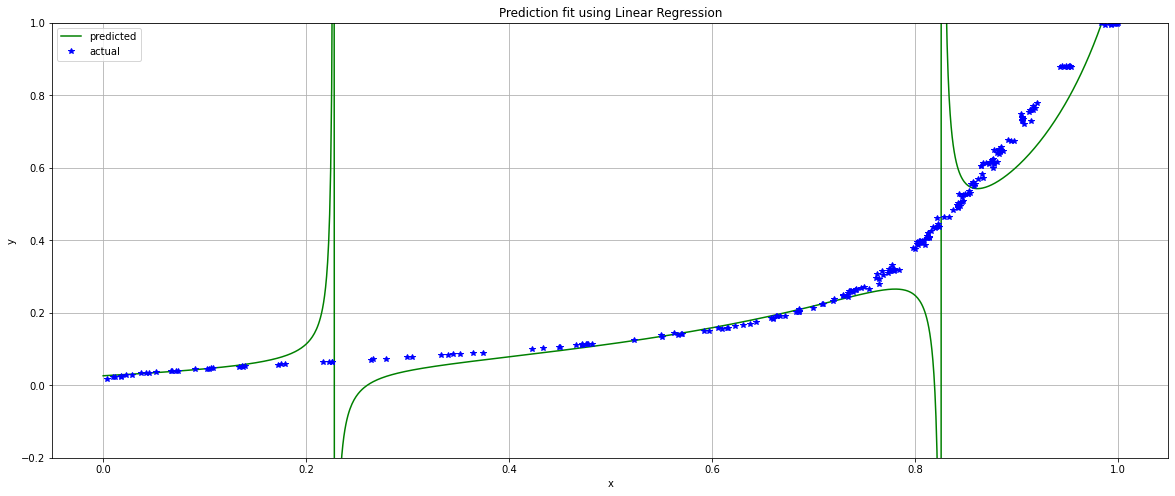

In [8]:
xp = np.linspace(0,1,num=1000)
yhat = np.zeros(len(xp))
for i in range(len(xp)):
    yhat[i] = predict(winit,xp[i])
i = np.argsort(xts)
xts, yts = xts[i], yts[i]
plt.figure(figsize=(20,8))
plt.plot(xp,yhat,'g')
plt.plot(x,y,'*b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(('predicted','actual'))
plt.title('Prediction fit using Linear Regression')
plt.grid()
plt.ylim([-0.2,1])

(-0.2, 1.0)

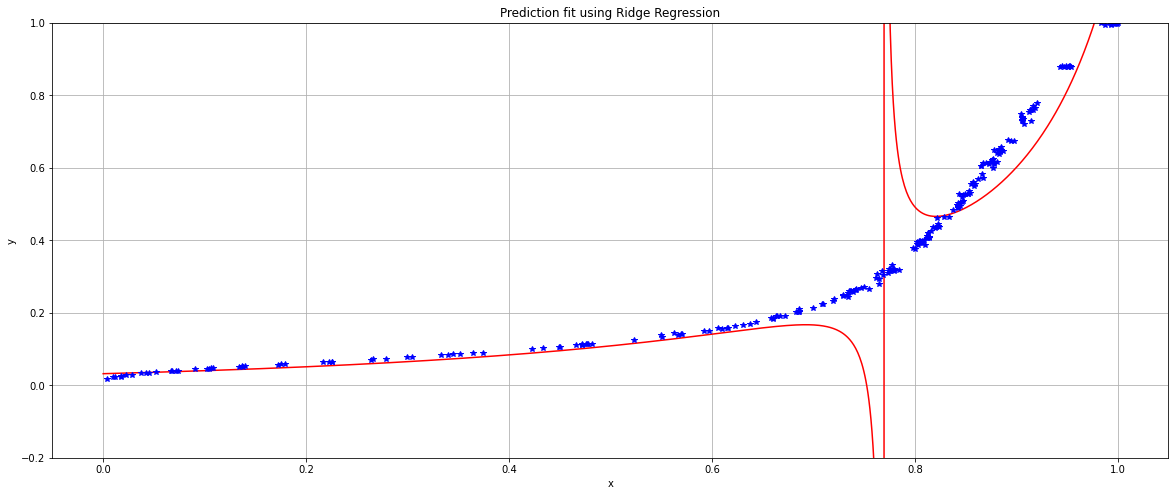

In [9]:
reg = Ridge(alpha=1e-3)
reg.fit(Z,ytr)
a = np.concatenate(([reg.intercept_],reg.coef_[0:d]))
b = -reg.coef_[d:]
winit = np.concatenate((a,b))

xp = np.linspace(0,1,num=1000)
yhat = np.zeros(len(xp))
yhat[:] = predict(winit,xp[:])
plt.figure(figsize=(20,8))
plt.plot(xp,yhat,'r')
plt.plot(x,y,'*b')
plt.xlabel('x') 
plt.ylabel('y')
plt.title('Prediction fit using Ridge Regression') 
plt.grid() 
plt.ylim([-0.2,1])

# Creating a Loss Function

In [10]:
def feval(w,x,y):
    d = (len(w)-1)//2
    a = w[0:d+1]
    b = w[d+1:]
    Znum = np.zeros((len(x),d+1))     
    for i in range(len(x)):
        for j in range(d+1): 
            Znum[i,j] = x[i]**j
    Zden = np.zeros((len(x),d))    
    for i in range(len(x)):
        for j in range(d): 
            Zden[i,j] = x[i]**(j+1)           
    yhat = np.zeros(len(x))     
    for i in range(len(x)):
        yhat[i] = Znum[i,:].dot(a)/(1+Zden[i,:].dot(b))                
    f = 0.5*np.sum(np.square(y-yhat))
    grada = np.zeros(len(a))     
    for j in range(len(a)):
        grada[j] = -np.sum((y-yhat)*Znum[:,j]/(1+np.matmul(Zden,b))) 
    gradb = np.zeros(len(b))    
    for j in range(len(b)):
        gradb[j] = np.sum((y-yhat)*yhat*Zden[:,j]/(1+np.matmul(Zden,b)))        
    fgrad = np.concatenate((grada,gradb)) 
    return f, fgrad

In [11]:
w0 = winit
f0, fgrad0 = feval(w0,xtr,ytr)
step = 1e-6
w1 = w0 + step
f1,fgrad1 = feval(w1,xtr,ytr)
print('Actual Difference: %.4f'%(f1-f0))
print('Predicted Difference using gradient: %.4f'%(fgrad0.dot(w1-w0)))

Actual Difference: 9.0558
Predicted Difference using gradient: 8.7825


# Implement gradient descent

(-3.0, 100.0)

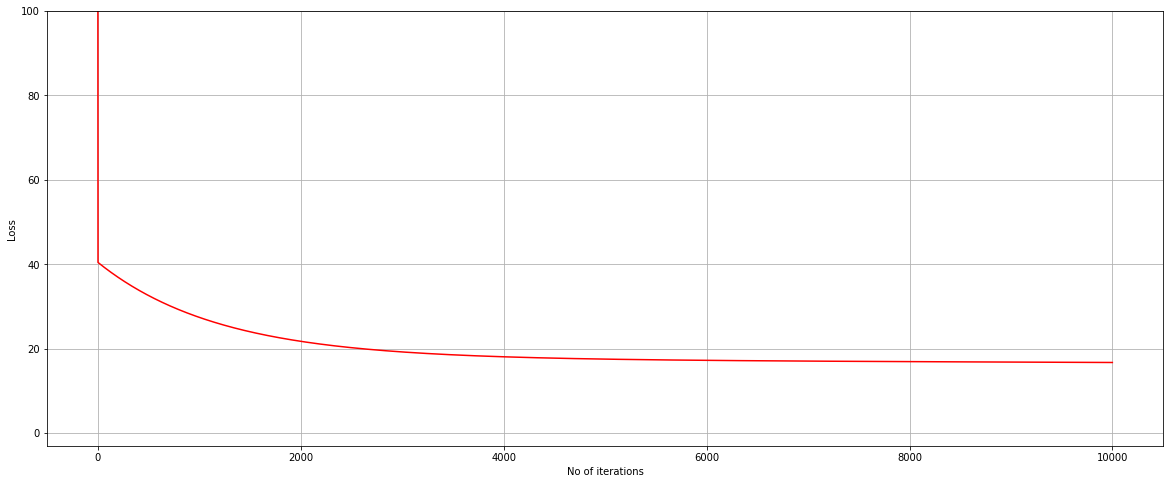

In [12]:
nit = 10000
step = 1e-6
hist = {'w': [], 'f': []}
for i in range(nit):
    f0, fgrad0 = feval(w0,xtr,ytr)
    w0 = w0 - fgrad0*step
    hist['w'].append(w0)
    hist['f'].append(f0)
    
for elem in ('f', 'w'):
    hist[elem] = np.array(hist[elem])

t = np.arange(nit)
loss = np.array(hist['f'])
plt.figure(figsize=(20,8))
plt.plot(t,loss,'r-')
plt.xlabel('No of iterations')
plt.ylabel('Loss')
plt.grid()
plt.ylim(-3,100)

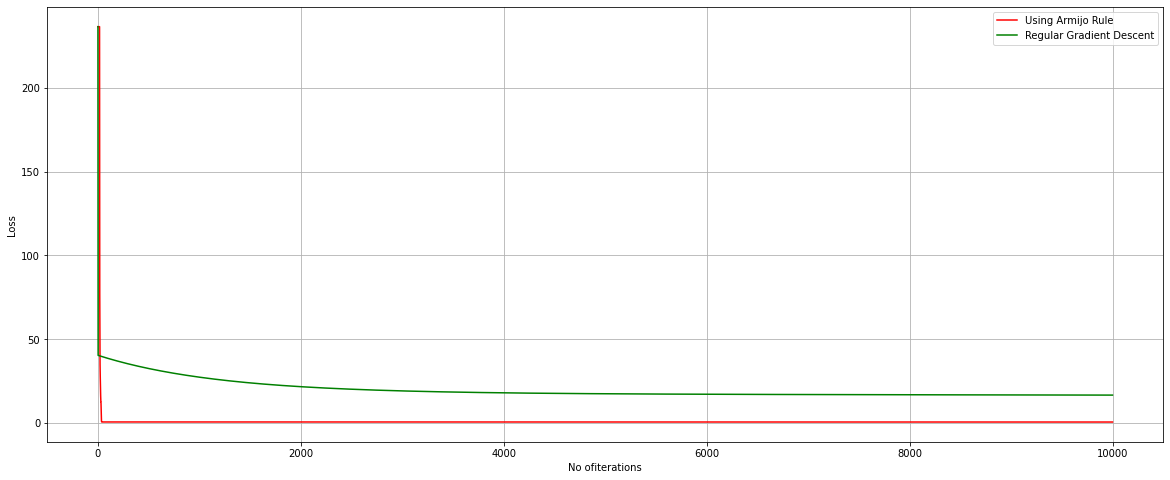

In [13]:
nit = 10000
step = 1e-6  # Initial step
hist = {'w':[],'f':[]}
w0 = winit; f0, fgrad0 = feval(winit,xtr,ytr) 
for i in range(nit):
    w1 = w0 - fgrad0*step
    f1, fgrad1 = feval(w1,xtr,ytr) 
    df = fgrad0.dot(w1-w0)
    al = 0.5
    if (f1-f0 < al*df) and (f1<f0):
        step = step*2
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
    else:
        step = step/2
    hist['w'].append(w0)
    hist['f'].append(f0)
    
loss_arm = np.array(hist['f'])
plt.figure(figsize=(20,8))
plt.plot(loss_arm,'r-')
plt.plot(loss,'g-')
plt.xlabel('No ofiterations')
plt.ylabel('Loss')
plt.grid()
plt.legend(('Using Armijo Rule','Regular Gradient Descent'))

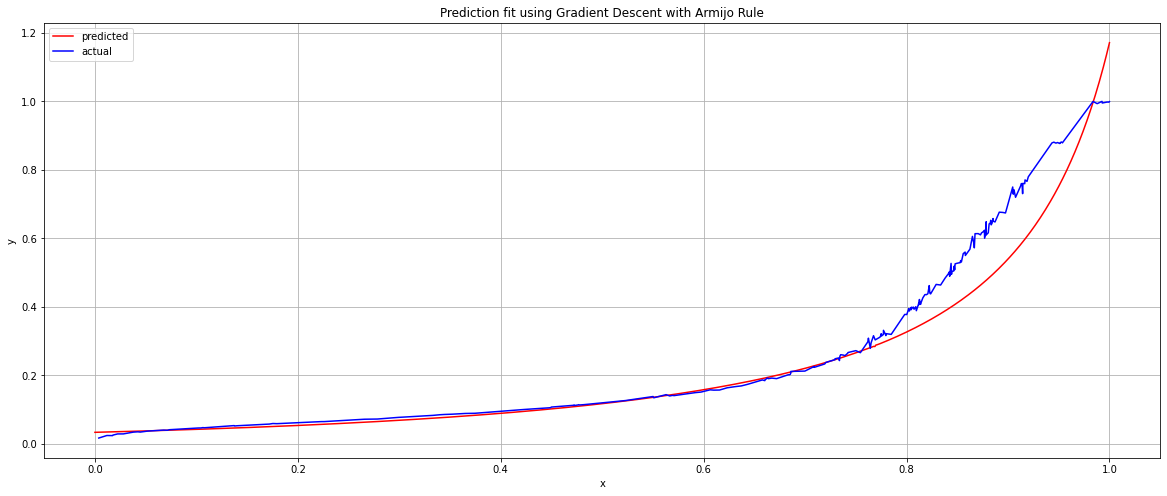

In [14]:
w2 = np.array(hist['w'])[10000-1,:]
xp = np.linspace(0,1,num=1000)
yhat = predict(w2,xp)
plt.figure(figsize=(20,8))
plt.plot(xp,yhat,'r')
plt.plot(x,y,'b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(('predicted','actual'))
plt.title('Prediction fit using Gradient Descent with Armijo Rule')
plt.grid()

# Momentum Gradient Descent

In [15]:
nit = 10000
step = 1e-5
beta = 0.99
z = np.zeros(np.shape(winit))
hist = {'w':[],'f':[]}
w3 = winit
for i in range(nit):
    f0, fgrad0 = feval(w3,xtr,ytr)
    z = z*beta + fgrad0
    w3 = w3 - z*step
    hist['w'].append(w3)
    hist['f'].append(f0)
loss_momentum = np.array(hist['f'])

(0.0, 100.0)

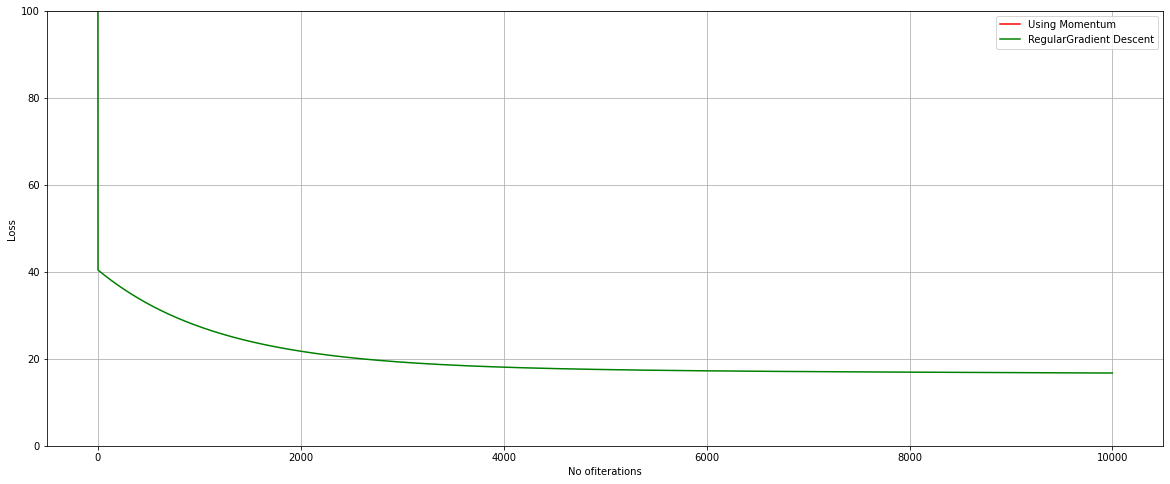

In [17]:
plt.figure(figsize=(20,8))
plt.plot(loss_momentum,'r-')
plt.plot(loss,'g-')
plt.xlabel('No ofiterations')
plt.ylabel('Loss')
plt.grid()
plt.legend(('Using Momentum','RegularGradient Descent'))
plt.ylim([0,100])